In [1]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os, datetime
from shapely.geometry.polygon import Polygon, Point
from dateutil.rrule import rrule, MONTHLY
from dateutil.parser import parse

import folium
import matplotlib.colors as colors
from branca.element import Figure

In [2]:
%%time
import pandas as pd

# Lee el archivo CSV
df = pd.read_csv('./fullData/full_dataSorted.csv', parse_dates=['Datetime'])

# Muestra el dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80775584 entries, 0 to 80775583
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Fecha          object        
 1   Hora           object        
 2   latitud        float64       
 3   longitud       float64       
 4   corrientePico  float64       
 5   Datetime       datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 3.6+ GB
None
CPU times: user 1min 57s, sys: 9.09 s, total: 2min 6s
Wall time: 2min 6s


In [3]:
intervalo=0.1

latMin=20.82693622940
latMax=32.04711710440
lonMin=-113.37002358900
lonMax=-102.09568904000

latInterval = np.arange(latMin, latMax, intervalo*2)

lonInterval = np.arange(abs(lonMax), abs(lonMin), intervalo*2)

points=[]
for i in latInterval:
    for j in lonInterval:
        points.append([-j,i])
print(len(latInterval))      
print(len(lonInterval))
print(len(points))

57
57
3249


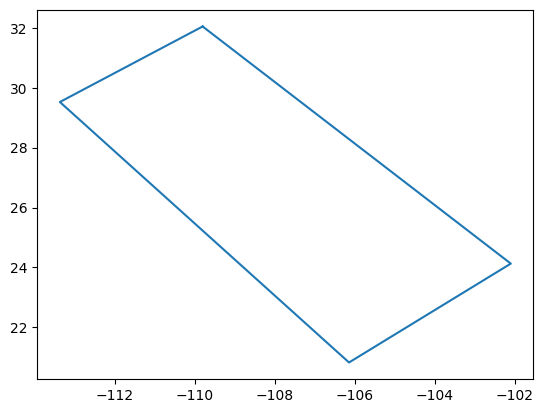

In [4]:
coord = [[-109.80083208100, 32.04711710440],
        [-102.09568904000, 24.12843837480],
        [-106.14077274900, 20.82693622940],
        [-113.37002358900, 29.52488843780]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.show()

In [5]:
%%time
poly = Polygon(coord)
puntosDentro=[]
# Verificar si cada punto está dentro del polígono
for point in points:
    if poly.contains(Point(point)):
        puntosDentro.append(point)
puntosT1xy=puntosDentro
print(len(puntosDentro))

1334
CPU times: user 138 ms, sys: 1.01 ms, total: 139 ms
Wall time: 143 ms


In [6]:
fecha_inicio = parse(df["Fecha"][0])

fecha_fin = parse(df["Fecha"][len(df)-1])

distancia=intervalo

In [7]:
%%time
registros=[]
for fecha in rrule(MONTHLY, dtstart=fecha_inicio, until=fecha_fin):

    dfTemp=df[(df['Datetime'] >= fecha) & (df['Datetime'] <= fecha + pd.DateOffset(months=1))]
    row=[]
    #print(dfTemp)
    for iRow in puntosT1xy:
        #print(len(dfTemp))
 
        #cercanosTemp=dfTemp.loc[(np.abs(dfTemp['latitud'] - iRow[1])<(2*distancia)) & (np.abs(dfTemp['longitud'] - iRow[0])<(2*distancia))]
        cercanos=dfTemp.loc[(np.sqrt((dfTemp['latitud'] - iRow[1])**2 + (dfTemp['longitud'] - iRow[0])**2)) < distancia]
        #print(len(cercanos))
        if(len(cercanos)!=0):
            horaMax=cercanos["Datetime"].groupby([cercanos["Datetime"].dt.hour]).count().idxmax()
        else:
            horaMax=-1
        row.append(horaMax)
    registros.append(row)

CPU times: user 22min 29s, sys: 2min 43s, total: 25min 13s
Wall time: 25min 11s


In [8]:
%%time
puntosT1xyCopy=copy.deepcopy(puntosT1xy)

for mes in range(len(registros)):
    y=0
    for i in puntosT1xyCopy:
        i.append(registros[mes][y])
        y=y+1


CPU times: user 25.3 ms, sys: 1.04 ms, total: 26.4 ms
Wall time: 25.7 ms


In [9]:
print("Resumen de la información:")
print("Coordenadas: "+str(len(puntosT1xyCopy)))
print("Meses: "+str(len(puntosT1xyCopy[0])-2))

print("Fecha inicial: "+ str(fecha_inicio ))
print("Fecha final: " +str(fecha_fin))

print("Distancia maxima en grados: "+str(distancia))

Resumen de la información:
Coordenadas: 1334
Meses: 60
Fecha inicial: 2015-01-01 00:00:00
Fecha final: 2019-12-31 00:00:00
Distancia maxima en grados: 0.1


In [10]:
path='./Resultados/'+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
if not os.path.exists(path):
    os.makedirs(path)
path

'./Resultados/2023-06-26_18-51-21'

In [11]:
radioMetros=9000
meses=["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

In [12]:
%%time
import branca.colormap as cm

colors = cm.LinearColormap([colors.rgb2hex(rgba) for rgba in plt.cm.Spectral(np.linspace(0, 1, 24))], vmin=0, vmax=23, max_labels =24)

# Define los puntos de interés como un arreglo de coordenadas
puntos_de_interes = puntosT1xyCopy


# Agrega los puntos de interés al mapa
for mes in range(len(puntos_de_interes[0])-2):
    
    mapa = folium.Map(location=[27.0862, -107.41912], zoom_start=7)
    for punto in puntos_de_interes:
        if(punto[mes+2]!=-1):
            circle=folium.Circle(
                location=[punto[1], punto[0]],
                radius=radioMetros,
                color=colors(punto[mes+2]),
                fill=True,
                fill_color=colors(punto[mes+2])
            )
            folium.Marker(
                location=[punto[1], punto[0]],
                icon=folium.DivIcon(html=f"""<div style="text-align:center; width: 10px; color: black;">{punto[mes+2]}</div>""")
            ).add_to(mapa)
            circle.add_to(mapa)

    
    colors.caption = 'Color Scale'
    mapa.add_child(colors)  

    fig = Figure(width=1000, height=1200)
    fig.add_child(mapa)
    mapa.save(path+"/map_"+str(2015+(mes//12))+"_"+str(meses[mes%12])+".html")

CPU times: user 1min 22s, sys: 2.98 s, total: 1min 25s
Wall time: 1min 26s


In [13]:
r1="Resumen de la información:\n\n"
r2="Coordenadas: "+str(len(puntosT1xyCopy))+"\n\n"
r3="Meses: "+str(len(puntosT1xyCopy[0])-2)+"\n\n"

r4="Fecha inicial: "+ str(fecha_inicio )+"\n\n"
r5="Fecha final: " +str(fecha_fin)+"\n\n"
r6="Distancia maxima en grados: "+str(distancia)+"\n\n"
r7="Radio de cada circulo:"+str(radioMetros)+"\n\n"
text=r1+r2+r3+r4+r5+r6+r7

In [ ]:
with open(path+'/info.txt', 'w') as f:
    f.write(text)
    